In [76]:
import json
import urllib.request as ur
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import lmfit
import scipy.stats as sts
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import chi2

from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mtick

from IPython.display import display, Markdown

In [2]:
def gompertz_function(x, a, b, k, e):
    exp = - np.exp(k * (b - x))
    return a * np.exp(exp) + e

def double_gompertz_function(x, a1, b1, k1, a2, b2, k2, e):
    exp1 = - np.exp(k1 * (b1 - x))
    g1 = a1 * np.exp(exp1)
    exp2 = - np.exp(k2 * (b2 - x))
    g2 = (a2 - a1) * np.exp(exp2)
    return g1 + g2 + e

def logit_function(x, a, b, k, e):
    d = k * (b - np.array(x))
    return (a / (1 + np.exp(d))) + e

def double_logit_function(x, a1, b1, k1, a2, b2, k2, e):
    d1 = k1 * (b1 - np.array(x))
    l1 = a1 / (1 + np.exp(d1))
    d2 = k2 * (b2 - np.array(x))
    l2 = (a2 - a1) / (1 + np.exp(d2))
    return l1 + l2 + e

In [3]:
df = pd.read_pickle("data-confirmed-2020-04-29.pkl")

In [511]:
def find_outliers(df, func_name, threshold=1.5, best=True):
    aic_outliers = {}
    redchi_outliers = {}
    bic_outliers = {}
    
    aics = []     # Akaike Information Criterion    # compare between models
    redchis = []  # Reduced chi-square              # the more near 1 the better
    bics = []     # Bayesian Information Criterion  # the higher the better
    
    for country in df[func_name].index:
        if country == 'Yemen':
            aics.append(0)
            redchis.append(0)
            bics.append(0)
            continue
        aics.append(df[func_name][country].aic)
        redchis.append(df[func_name][country].redchi)
        bics.append(df[func_name][country].bic)
    
    aics_mean = np.mean(aics)
    redchis_mean = np.mean(redchis)
    bics_mean = np.mean(bics)
    
    print(f"aic mean:{aics_mean} redchi mean:{redchis_mean} bic mean:{bics_mean}")
    
    aics_std = np.std(aics)
    redchis_std = np.std(redchis)
    bics_std = np.std(bics)
    
    print(f"aic std:{aics_std} redchi std:{redchis_std} bic std:{bics_std}")
    
    for i, aic in enumerate(aics):
        aics_z_score = (aic - aics_mean) / aics_std
        if np.abs(aics_z_score) > threshold:
            if best and aics_z_score > 0:
                continue
            aic_outliers.update({df[func_name].index[i]: aic})

    for i, redchi in enumerate(redchis):
        redchis_z_score = (redchi - redchis_mean) / redchis_std
        if np.abs(redchis_z_score) > threshold:
            if best and redchis_z_score < 0:
                continue
            redchi_outliers.update({df[func_name].index[i]: redchi})
            
    for i, bic in enumerate(bics):
        bics_z_score = (bic - bics_mean) / bics_std
        if np.abs(bics_z_score) > threshold:
            if best and bics_z_score < 0:
                continue
            bic_outliers.update({df[func_name].index[i]: bic})

    return {"aic": aic_outliers, "redchi": redchi_outliers, "bic": bic_outliers}

In [512]:
bests = {}

In [513]:
best = find_outliers(df, "Gompertz Function")
bests.update({"Gompertz Function": best})

aic mean:521.2853713490993 redchi mean:382491.43282538565 bic mean:531.5693500750534
aic std:420.84074935068867 redchi std:2833731.3296425124 bic std:420.9106575224575


In [514]:
best = find_outliers(df, "Logit Function")
bests.update({"Logit Function": best})

aic mean:552.4210933894071 redchi mean:1611446.4595353287 bic mean:562.7050721153614
aic std:446.9895805534934 redchi std:16903993.338296246 bic std:447.05929232078347


In [515]:
best = find_outliers(df, "Double Gompertz Function")
bests.update({"Double Gompertz Function": best})

aic mean:455.44876175704223 redchi mean:131973.0317562804 bic mean:473.44572452746223
aic std:408.43036480052706 redchi std:1038113.6991725125 bic std:408.54157398105025


In [516]:
best = find_outliers(df, "Double Logit Function")
bests.update({"Double Logit Function": best})

aic mean:499.33927990316454 redchi mean:422860.4481381729 bic mean:517.3362426735846
aic std:425.5641743932412 redchi std:3711966.7202850524 bic std:425.6809922149909


In [519]:
def get_models_stats(df):
   
    aics = {}     # Akaike Information Criterion    # compare between models
    redchis = {}  # Reduced chi-square              # the more near 1 the better
    bics = {}     # Bayesian Information Criterion  # the higher the better

    for f in df:
        if f == "measured":
            continue
        aics.update({f: []})
        redchis.update({f: []})
        bics.update({f: []})
        for country in df[f].index:
            if country == 'Yemen':
                aics[f].append(0)
                redchis[f].append(0)
                bics[f].append(0)
                continue
            aics[f].append(df[f][country].aic)
            redchis[f].append(df[f][country].redchi)
            bics[f].append(df[f][country].bic)

    return {"aic": aics, "redchi": redchis, "bic": bics}

In [520]:
_stats = get_models_stats(df)

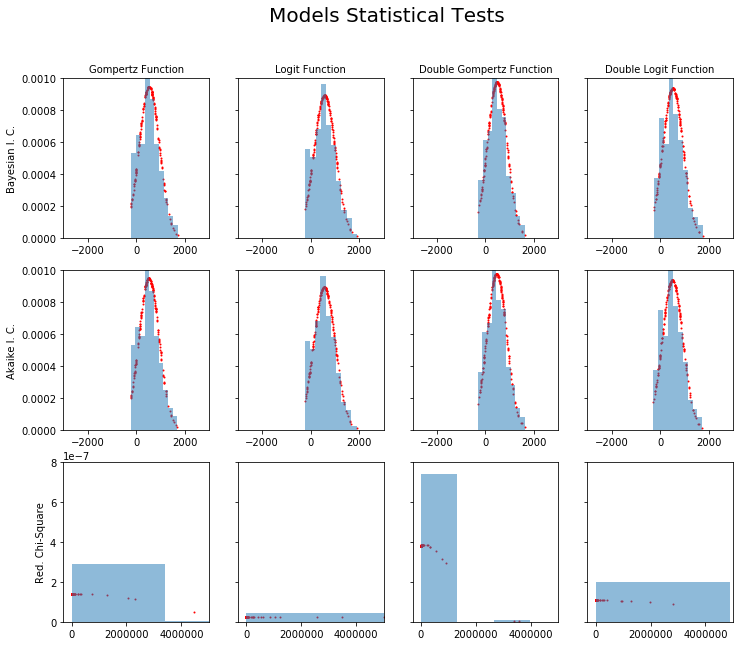

In [521]:
x = np.arange(0, len(_stats["bic"]["Gompertz Function"]))

fig, axs = plt.subplots(3, 4, figsize=(12, 10))

for i, f in enumerate(_stats["bic"]):
    fit = sts.norm.pdf(
        sorted(_stats["bic"][f]),
        np.mean(_stats["bic"][f]),
        np.std(_stats["bic"][f])
    )
    axs.flat[i].hist(
        sorted(_stats["bic"][f]),
        density=True, alpha=.5
    )
    axs.flat[i].scatter(
        sorted(_stats["bic"][f]), fit,
        c="r", s=1
    )
    axs.flat[i].set_title(f, fontsize=10)
    axs.flat[i].set_ylim(0, .001)    
    axs.flat[i].set_xlim(-3000, 3000)
    if i:
        axs.flat[i].set_yticklabels([])
    if not i:
        axs.flat[i].set_ylabel("Bayesian I. C.")

for i, f in enumerate(_stats["aic"]):
    fit = sts.norm.pdf(
        sorted(_stats["aic"][f]),
        np.mean(_stats["aic"][f]),
        np.std(_stats["aic"][f])
    )
    
    axs.flat[i+4].scatter(
        sorted(_stats["aic"][f]), fit,
        c="r", s=1
    )
    axs.flat[i+4].hist(
        sorted(_stats["aic"][f]),
        density=True, alpha=.5
    )
    axs.flat[i+4].set_ylim(0, .001)    
    axs.flat[i+4].set_xlim(-3000, 3000)
    if i:
        axs.flat[i+4].set_yticklabels([])
    if not i:
        axs.flat[i+4].set_ylabel("Akaike I. C.")
    
for i, f in enumerate(_stats["redchi"]):
    fit = sts.norm.pdf(
        sorted(_stats["redchi"][f]),
        np.mean(_stats["redchi"][f]),
        np.std(_stats["redchi"][f])
    )
    
    axs.flat[i+8].scatter(
        sorted(_stats["redchi"][f]), fit,
        c="r", s=1
    )
    axs.flat[i+8].hist(
        sorted(_stats["redchi"][f]),
        density=True, alpha=.5
    )
    axs.flat[i+8].set_ylim(0, 8e-7)
    axs.flat[i+8].set_xlim(-3e5, 0.5e7)
    if i:
        axs.flat[i+8].set_yticklabels([])
    if not i:
        axs.flat[i+8].set_ylabel("Red. Chi-Square")
    
    
fig.suptitle("Models Statistical Tests", fontsize=20)
plt.show()

In [526]:
def get_models_residual(df):
   
    res = {}

    for f in df:
        if f == "measured":
            continue
        res.update({f: []})
        for country in df[f].index:
            if country == 'Yemen':
                continue
            res[f] = np.concatenate((
                res[f],
                df[f][country].residual
            ))

    return res

In [527]:
residual = get_models_residual(df)

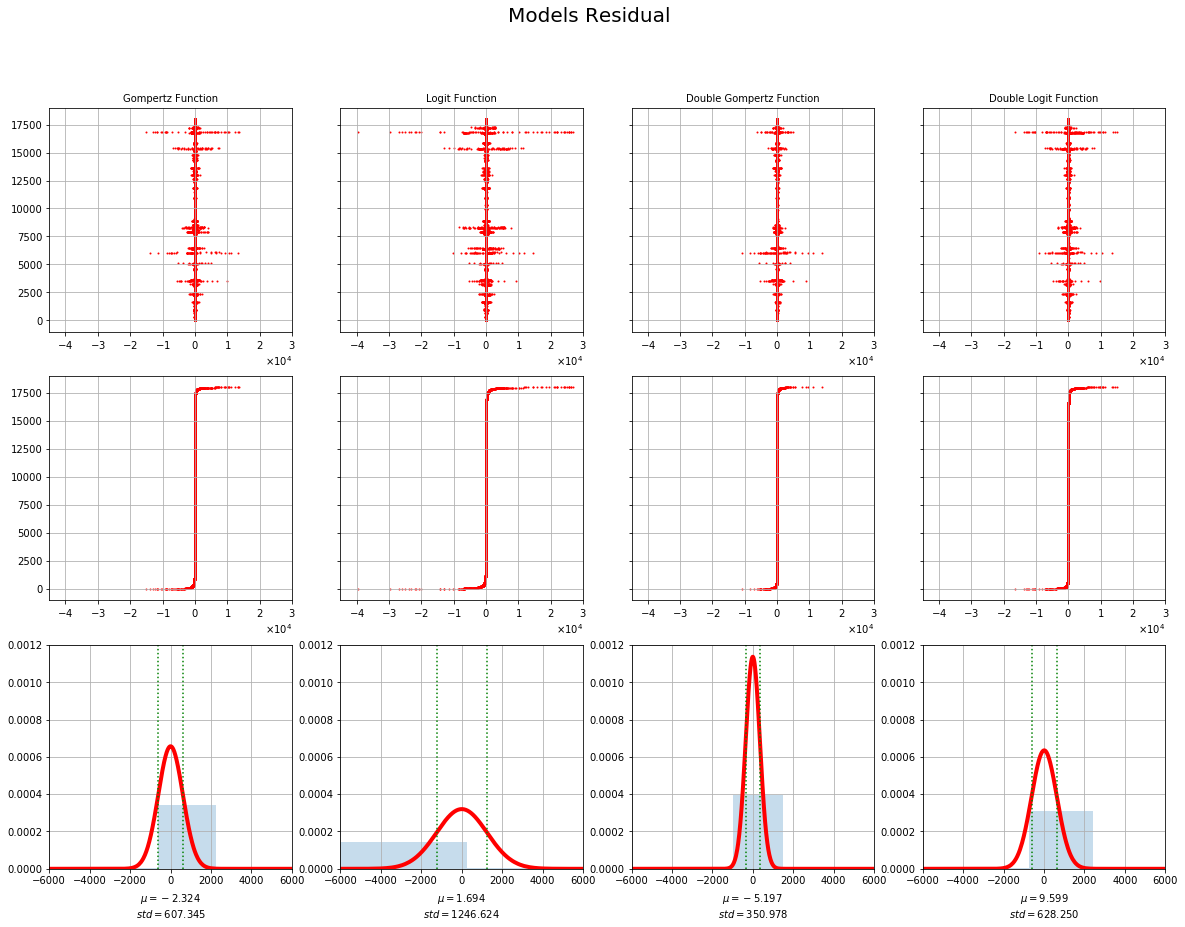

In [528]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))

size = 4

fig, axs = plt.subplots(3, 4, figsize=(5*size, 3.5*size))

for i, f in enumerate(residual):
    axs.flat[i].scatter(
        residual[f], np.arange(0, len(residual[f])), 
        c="r", s=1
    )
    axs.flat[i].set_title(f, fontsize=10)
    axs.flat[i].grid(True)
    axs.flat[i].set_xlim(-4.5e4, 3e4)
    axs.flat[i].set_ylim(-1e3, 1.9e4)
    axs.flat[i].xaxis.set_major_formatter(formatter)
    if i:
        axs.flat[i].yaxis.set_ticklabels([])

for i, f in enumerate(residual):
    axs.flat[i+4].scatter(
        sorted(residual[f]), np.arange(0, len(residual[f])), 
        c="r", s=1
    )
    axs.flat[i+4].grid(True)
    axs.flat[i+4].set_xlim(-4.5e4, 3e4)
    axs.flat[i+4].set_ylim(-1e3, 1.9e4)
    axs.flat[i+4].xaxis.set_major_formatter(formatter)
    if i:
        axs.flat[i+4].yaxis.set_ticklabels([])
    
for i, f in enumerate(residual):
    mean = np.mean(residual[f])
    std = np.std(residual[f])
    fit = sts.norm.pdf(
        sorted(residual[f]),
        mean,
        std
    )
    axs.flat[i+8].hist(
        sorted(residual[f]),
        density=True, alpha=.25,
    )
    axs.flat[i+8].plot(
        sorted(residual[f]), fit,
        c="r", lw=4
    )

    axs.flat[i+8].axvline(mean + std, ls=":", c="g")
    axs.flat[i+8].axvline(mean - std, ls=":", c="g")
    axs.flat[i+8].set_xlabel(f"$\mu = {mean:.3f}$\n$std = {std:.3f}$")
    axs.flat[i+8].grid(True)
    axs.flat[i+8].set_ylim(0, 1.2e-3)
    axs.flat[i+8].set_xlim(-6e3, 6e3)
    
    
fig.suptitle("Models Residual", fontsize=20)
plt.show()

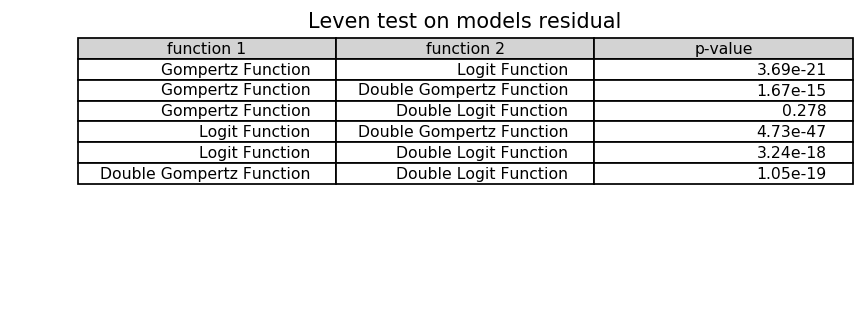

In [533]:
from itertools import combinations as combs

table = []

for i, f in enumerate(combs(residual, 2)):
    if f == "measured":
        continue
    l = sts.levene(
        residual[f[0]],
        residual[f[1]]
    )
    table.append([f[0], f[1], f"{l.pvalue:.3f}" if l.pvalue > .1 else f"{l.pvalue:.2e}"])

fig, ax = plt.subplots(figsize=(8, 1), dpi=125)
plt.axis('tight')
plt.axis("off")
ax.table(
    cellText=table,
    colLabels=["function 1", "function 2", "p-value"],
    loc="top", colColours=["lightgrey", "lightgrey", "lightgrey"]
)
ax.set_title("Leven test on models residual", pad=90)
plt.show()

In [534]:
def get_models_predictions(df):
   
    res = {}

    for f in df:
        if f == "measured":
            continue
        res.update({f: []})
        for country in df[f].index:
            if country == 'Yemen':
                continue
            res[f] = np.concatenate((
                res[f],
                df[f][country].best_fit
            ))

    return res

In [535]:
y_true = []
for country in df["measured"].index:
    if country == 'Yemen':
        continue
    _y = df["measured"][country]
    y_true = np.concatenate((y_true, _y))

In [536]:
y_pred = get_models_predictions(df)

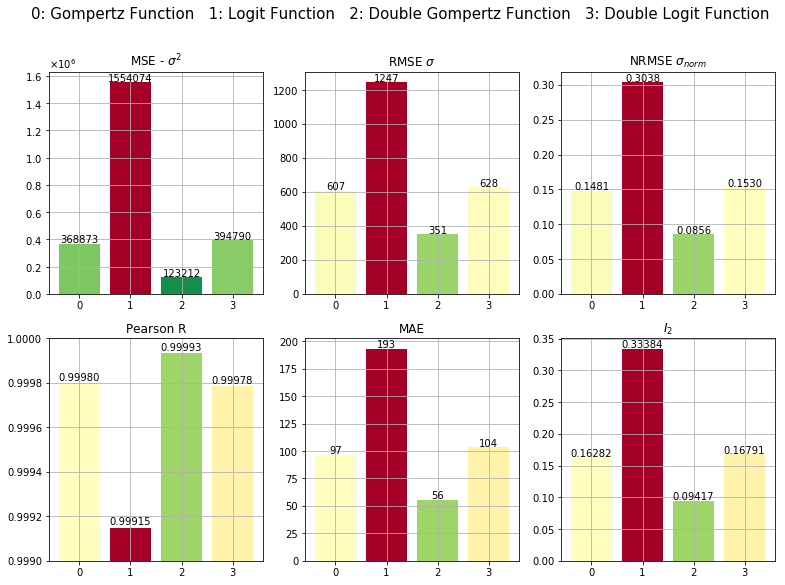

In [601]:
fig, axs = plt.subplots(2, 3, figsize=(13, 9))

colors = cm.RdYlGn_r(np.arange(1, 10))

mse_x = np.arange(4)
mse_y = []
for f in y_pred:
    mse = mean_squared_error(y_true, y_pred[f])
    mse_y.append(mse)
colors = cm.RdYlGn_r(np.array(mse_y) / max(mse_y))
rects = axs.flat[0].bar(mse_x, mse_y,color=colors)
for i, _y in enumerate(mse_y):
    axs.flat[0].annotate(s=f"{_y:.0f}", xy=(i, _y), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[0].yaxis.set_major_formatter(formatter)
axs.flat[0].grid(True)
axs.flat[0].set_title("MSE - $\sigma^2$")

rmse_x = np.arange(4)
rmse_y = []
for f in y_pred:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred[f]))
    rmse_y.append(rmse)
colors = cm.RdYlGn_r(np.array(rmse_y) / max(rmse_y))
rects = axs.flat[1].bar(rmse_x, rmse_y,color=colors)
for i, _y in enumerate(rmse_y):
    axs.flat[1].annotate(s=f"{_y:.0f}", xy=(i, _y), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[1].grid(True)
axs.flat[1].set_title("RMSE $\sigma$")

rmse_x = np.arange(4)
rmse_y = []
for f in y_pred:
    normalizer = np.sum(y_pred[f]) / len(y_pred)
    rmse = np.sqrt(
        mean_squared_error(y_true, y_pred[f]) / normalizer
    )
    rmse_y.append(rmse)
colors = cm.RdYlGn_r(np.array(rmse_y) / max(rmse_y))
rects = axs.flat[2].bar(rmse_x, rmse_y,color=colors)
for i, _y in enumerate(rmse_y):
    axs.flat[2].annotate(s=f"{_y:.4f}", xy=(i, _y), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[2].grid(True)
axs.flat[2].set_title("NRMSE $\sigma_{norm}$")

mae_x = np.arange(4)
mae_y = []
for f in y_pred:
    mae = mean_absolute_error(y_true, y_pred[f])
    mae_y.append(mae)
colors = cm.RdYlGn_r(np.array(mae_y) / max(mae_y))
rects = axs.flat[4].bar(mae_x, mae_y,color=colors)
for i, _y in enumerate(mae_y):
    axs.flat[4].annotate(s=f"{_y:.0f}", xy=(i, _y), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[4].grid(True)
axs.flat[4].set_title("MAE")

pearson_r_x = np.arange(4)
pearson_r_y = []
for f in y_pred:
    pearson_r = sts.pearsonr(y_true, y_pred[f])
    pearson_r_y.append(pearson_r[0])
min_y = 0.999
rects = axs.flat[3].bar(pearson_r_x, pearson_r_y,color=colors)
for i, _y in enumerate(pearson_r_y):
    axs.flat[3].annotate(s=f"{_y:.5f}", xy=(i, _y), ha='center', xytext=(0, 3), textcoords="offset points")
axs.flat[3].grid(True)
axs.flat[3].set_ylim(min_y, 1)
axs.flat[3].set_title("Pearson R")

isq_x = np.arange(4)
isq_y = []
for f in y_pred:
    isq = np.sqrt(mean_squared_error(y_true, y_pred[f])) / (np.sum(y_pred[f]) / len(y_pred[f]))
    isq_y.append(isq)
rects = axs.flat[5].bar(
    isq_x, isq_y,
    color=colors
)
for i, _y in enumerate(isq_y):
    axs.flat[5].annotate(s=f"{_y:.5f}", xy=(i, _y), ha='center', xytext=(0, 1), textcoords="offset points")
axs.flat[5].grid(True)
axs.flat[5].set_title("$I_2$")

#plot = plt.scatter(np.arange(1, 10), np.arange(1, 10), c=np.arange(1, 10), cmap='RdYlGn_r')
#plt.clf()
#plt.colorbar(plot)
plt.suptitle(
    "   ".join([f"{i}: {f}" for i, f in enumerate(y_pred)]), fontsize=15
)
plt.show()

In [ ]:
AICys = {}

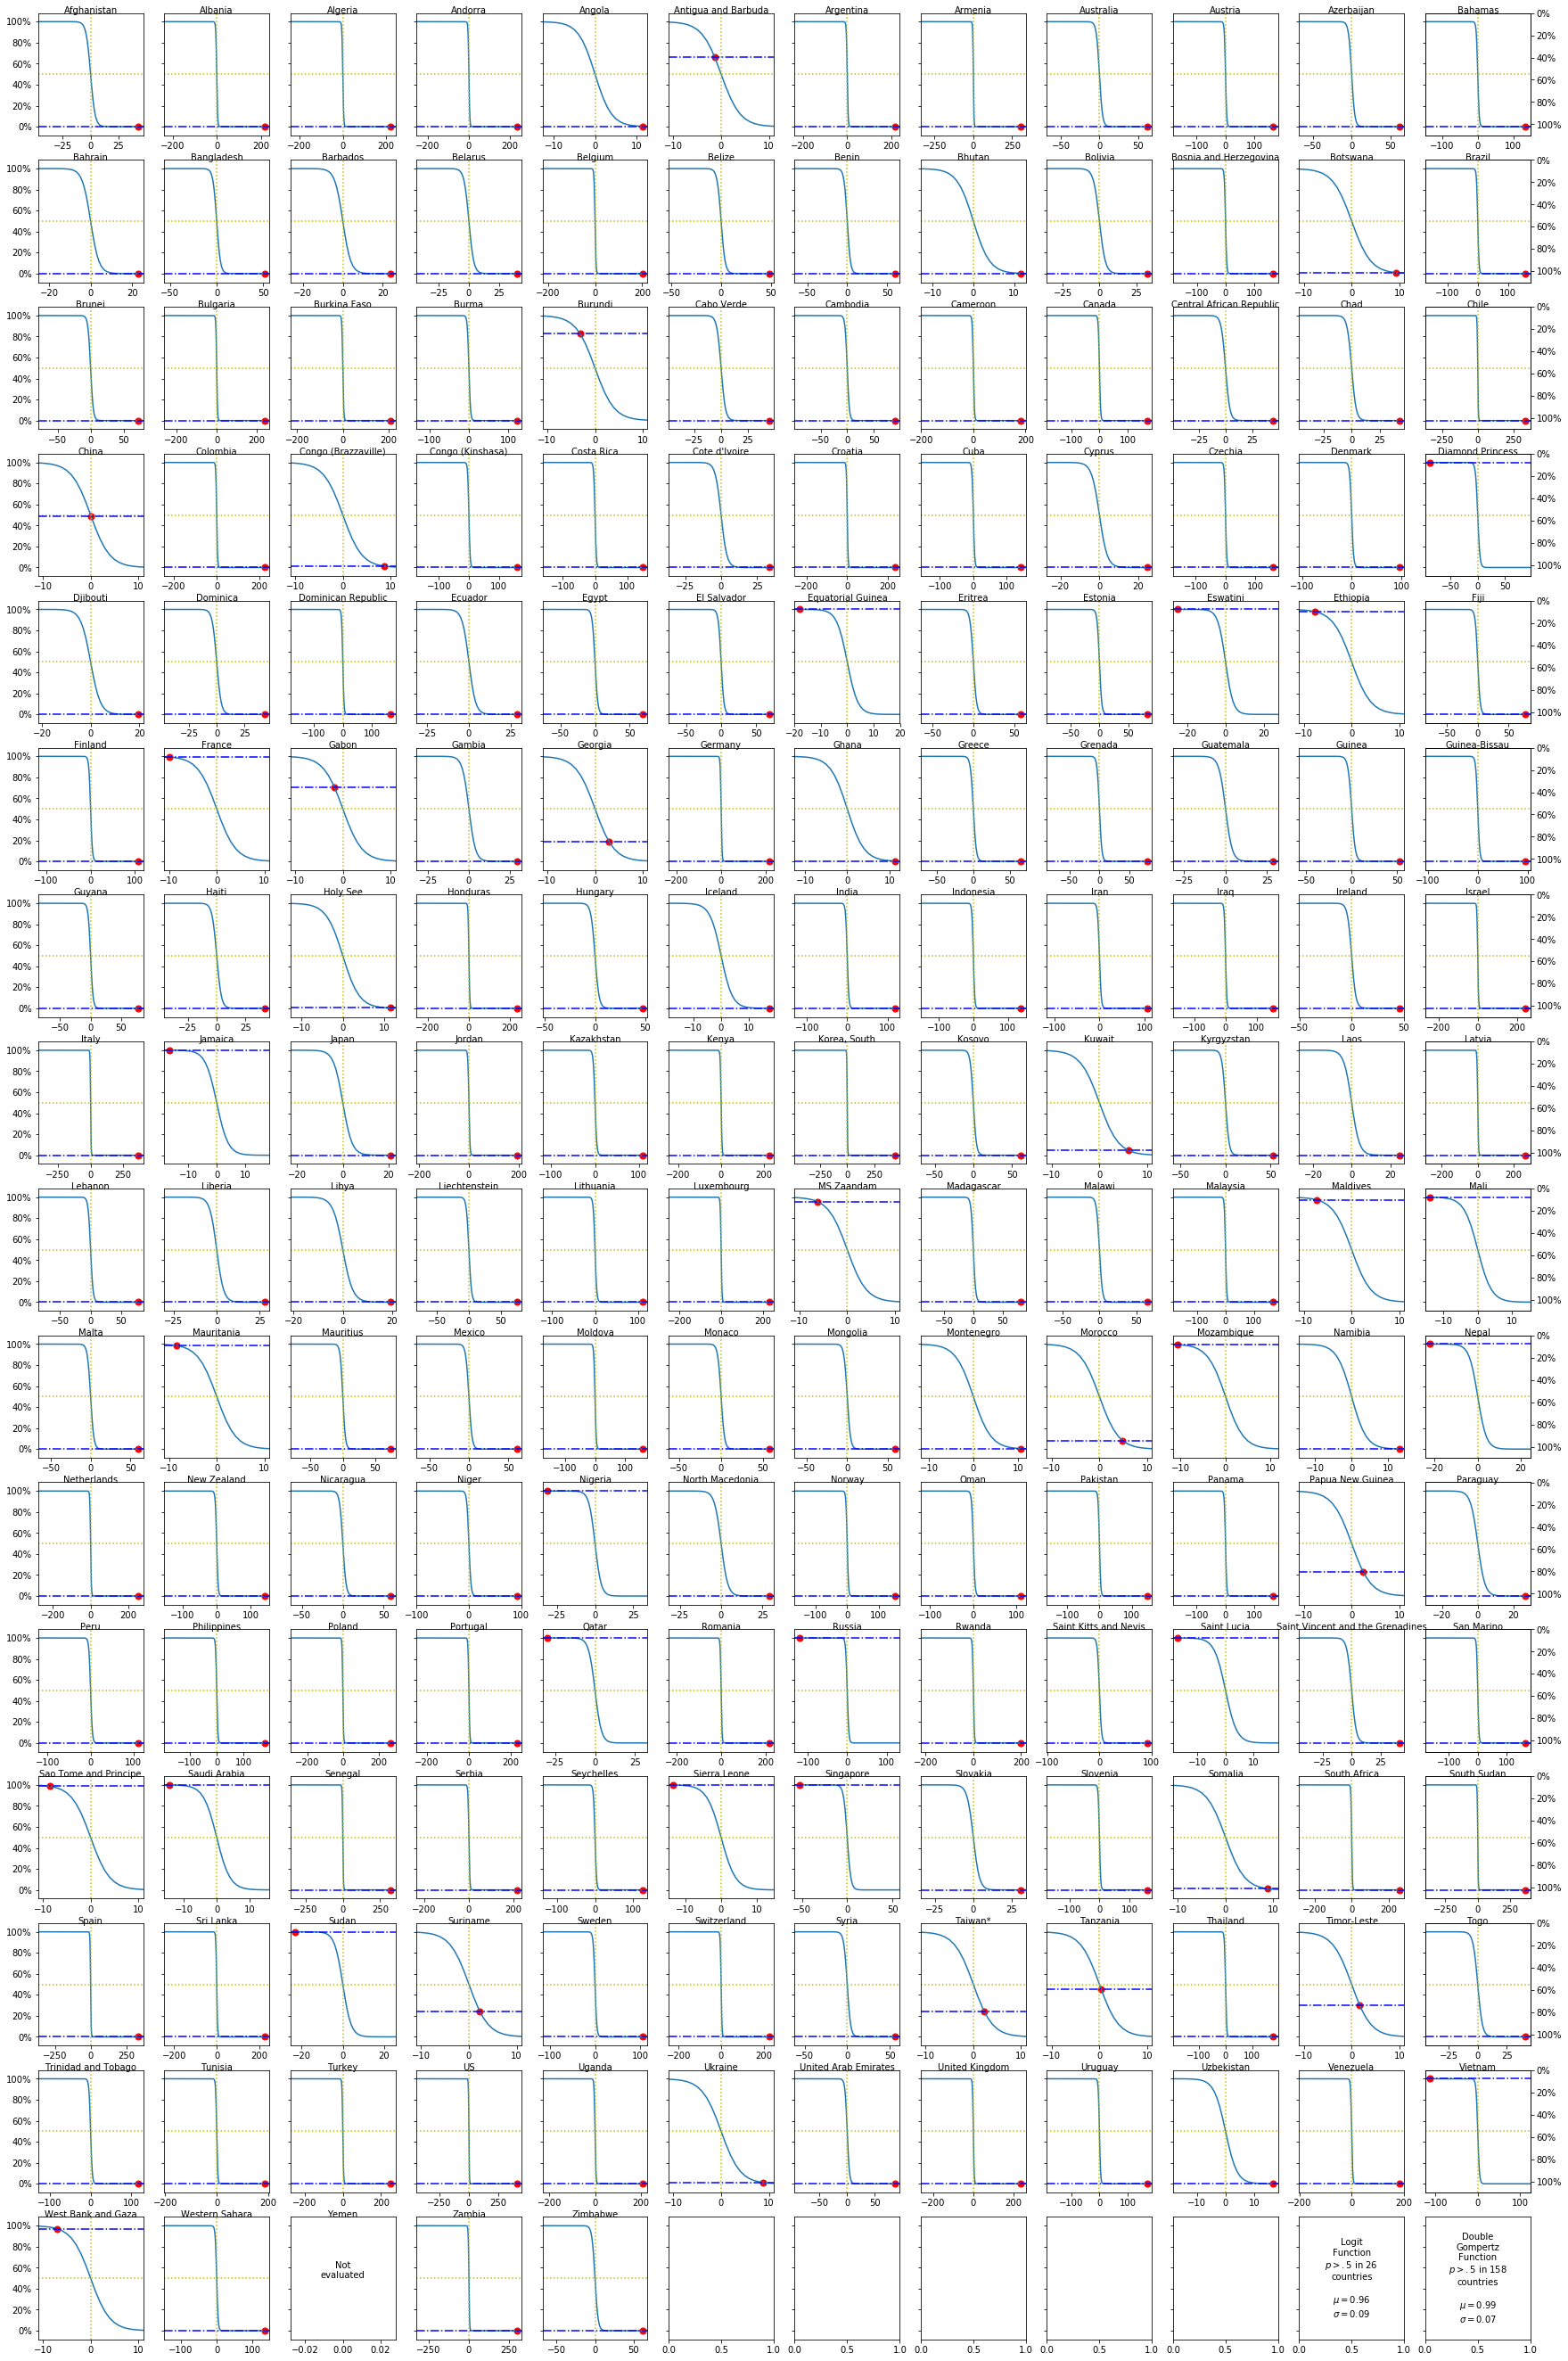

In [97]:
def AIC_distribution(diff):
    return np.exp(-.5 * diff) / (1 + np.exp(-.5 * diff))

evaluating = "Logit Function"

AICys.update({evaluating: np.array([])})

ncols = 12
nrows = int(np.ceil(df["measured"].size / ncols))

AICx = np.arange(-1e3, 1e3, 1)
AICy = AIC_distribution(AICx) * 100

fig, axs = plt.subplots(nrows, ncols, figsize=(30, 3 * nrows), sharey=True)

for i, country in enumerate(tqdm(df["measured"].index)):
    axs.flat[i].set_title(country, pad=-.5, fontsize=10)
    
    df1 = df[evaluating][country]
    df2 = df["Double Gompertz Function"][country]

    if not df1 or not df2:
        axs.flat[i].scatter([0], [0], alpha=0)
        axs.flat[i].text(0, 50, "Not\nevaluated", ha="center")
        continue

    AICdiff = df[evaluating][country].aic - df["Double Gompertz Function"][country].aic
    _y = AIC_distribution(AICdiff)
    AICys[evaluating] = np.append(AICys[evaluating], _y)
    axs.flat[i].plot(AICx, AICy)
    axs.flat[i].scatter(
        AICdiff, _y * 100,
        c="r", s=50
    )
    xlim = max(10, abs(AICdiff)) * 1.1
    axs.flat[i].set_xlim(-xlim, xlim)
    axs.flat[i].axvline(0, ls=":", c="y")
    axs.flat[i].axhline(50, ls=":", c="y")
    axs.flat[i].axhline(_y * 100, ls="-.", c="b")
    if i % ncols == ncols - 1:
        ax2 = axs.flat[i].twinx()
        ax2.set_ylim(110, -.110)
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

axs.flat[0].yaxis.set_major_formatter(mtick.PercentFormatter())

AICys1 = AICys[evaluating][AICys[evaluating]>.5]
AICys2 = AICys[evaluating][AICys[evaluating]<.5]
axs.flat[-2].text(
    x=.5, y=50, ha="center", va="center",
    s="""
{fname}
$p > .5$ in {num}
countries

$\mu = {mu:.2f}$
$\sigma = {sig:.2f}$
    """.format(
        fname=evaluating.replace(" ", "\n"),
        num=AICys1.size, mu=np.mean(AICys1), sig=np.std(AICys1)
    )
)
axs.flat[-1].text(
    x=.5, y=50, ha="center", va="center",
    s="""
{fname}
$p > .5$ in {num}
countries

$\mu = {mu:.2f}$
$\sigma = {sig:.2f}$
    """.format(
        fname="Double Gompertz Function".replace(" ", "\n"),
        num=AICys2.size, mu=np.mean(1 - AICys2), sig=np.std(1 - AICys2)
    )
)

plt.show()

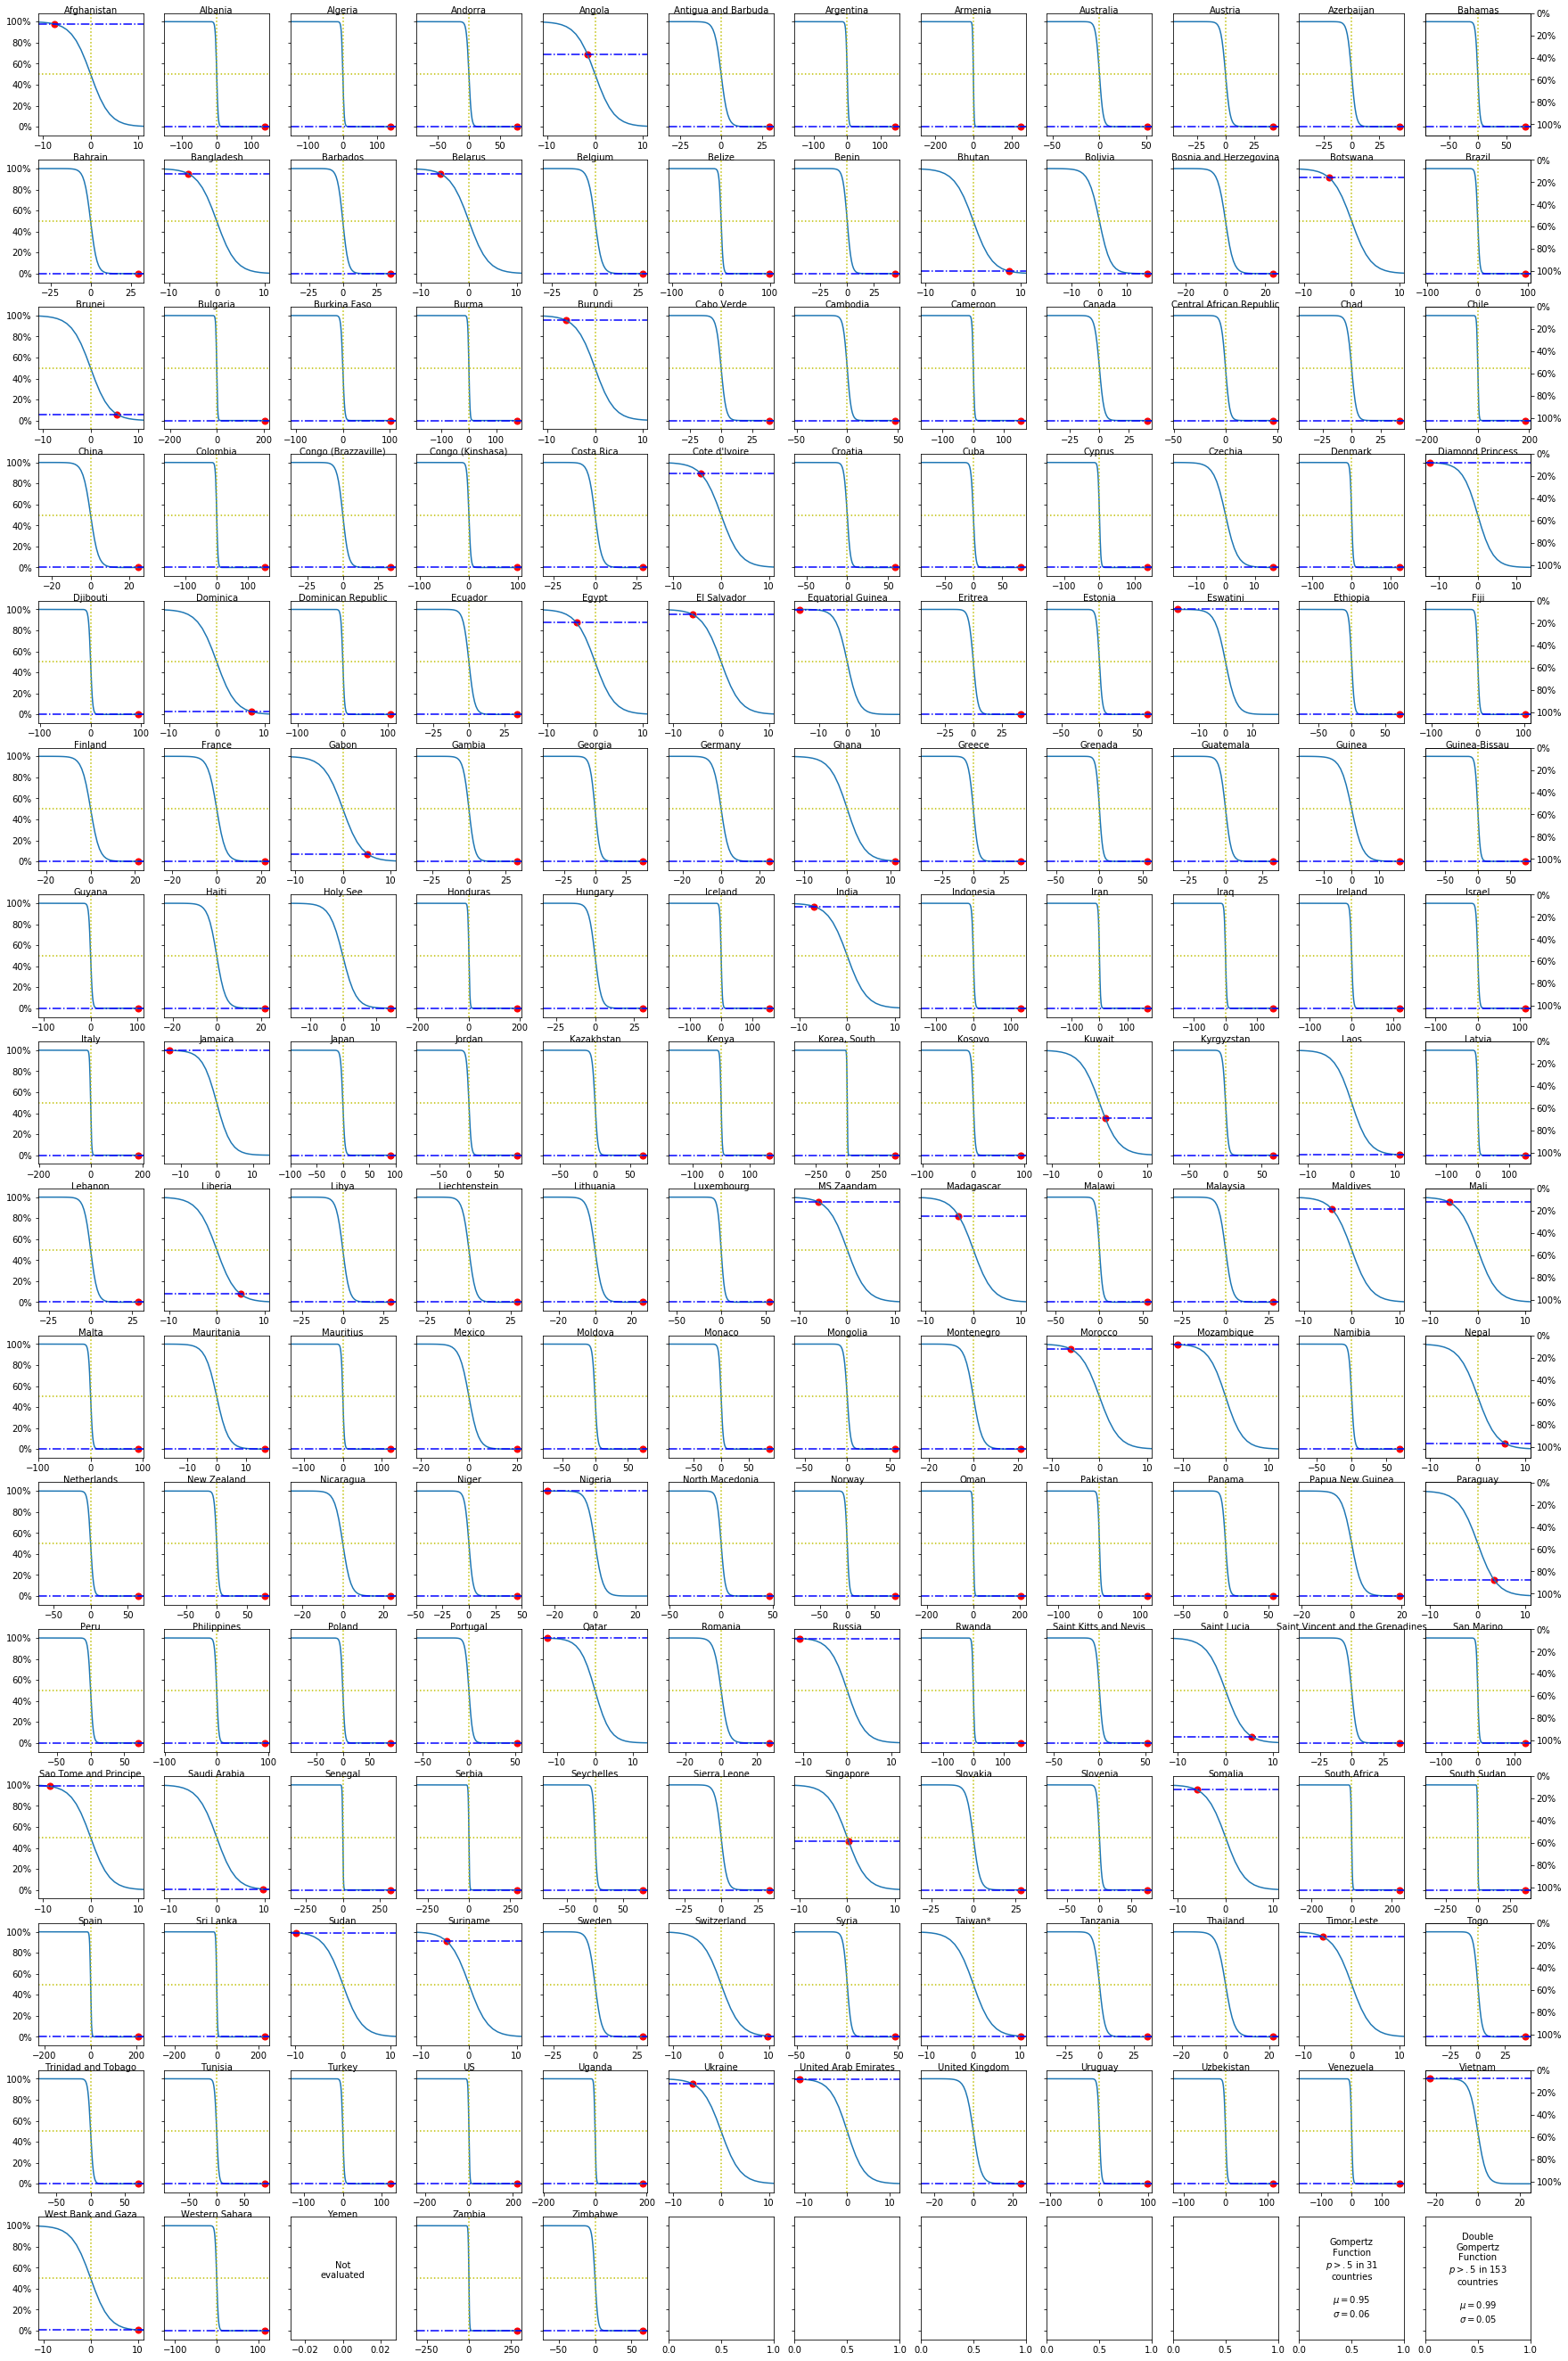

In [98]:
def AIC_distribution(diff):
    return np.exp(-.5 * diff) / (1 + np.exp(-.5 * diff))

evaluating = "Gompertz Function"

AICys.update({evaluating: np.array([])})

ncols = 12
nrows = int(np.ceil(df["measured"].size / ncols))

AICx = np.arange(-1e3, 1e3, 1)
AICy = AIC_distribution(AICx) * 100

fig, axs = plt.subplots(nrows, ncols, figsize=(30, 3 * nrows), sharey=True)

for i, country in enumerate(tqdm(df["measured"].index)):
    axs.flat[i].set_title(country, pad=-.5, fontsize=10)
    
    df1 = df[evaluating][country]
    df2 = df["Double Gompertz Function"][country]

    if not df1 or not df2:
        axs.flat[i].scatter([0], [0], alpha=0)
        axs.flat[i].text(0, 50, "Not\nevaluated", ha="center")
        continue

    AICdiff = df[evaluating][country].aic - df["Double Gompertz Function"][country].aic
    _y = AIC_distribution(AICdiff)
    AICys[evaluating] = np.append(AICys[evaluating], _y)
    axs.flat[i].plot(AICx, AICy)
    axs.flat[i].scatter(
        AICdiff, _y * 100,
        c="r", s=50
    )
    xlim = max(10, abs(AICdiff)) * 1.1
    axs.flat[i].set_xlim(-xlim, xlim)
    axs.flat[i].axvline(0, ls=":", c="y")
    axs.flat[i].axhline(50, ls=":", c="y")
    axs.flat[i].axhline(_y * 100, ls="-.", c="b")
    if i % ncols == ncols - 1:
        ax2 = axs.flat[i].twinx()
        ax2.set_ylim(110, -.110)
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

axs.flat[0].yaxis.set_major_formatter(mtick.PercentFormatter())

AICys1 = AICys[evaluating][AICys[evaluating]>.5]
AICys2 = AICys[evaluating][AICys[evaluating]<.5]
axs.flat[-2].text(
    x=.5, y=50, ha="center", va="center",
    s="""
{fname}
$p > .5$ in {num}
countries

$\mu = {mu:.2f}$
$\sigma = {sig:.2f}$
    """.format(
        fname=evaluating.replace(" ", "\n"),
        num=AICys1.size, mu=np.mean(AICys1), sig=np.std(AICys1)
    )
)
axs.flat[-1].text(
    x=.5, y=50, ha="center", va="center",
    s="""
{fname}
$p > .5$ in {num}
countries

$\mu = {mu:.2f}$
$\sigma = {sig:.2f}$
    """.format(
        fname="Double Gompertz Function".replace(" ", "\n"),
        num=AICys2.size, mu=np.mean(1 - AICys2), sig=np.std(1 - AICys2)
    )
)

plt.show()

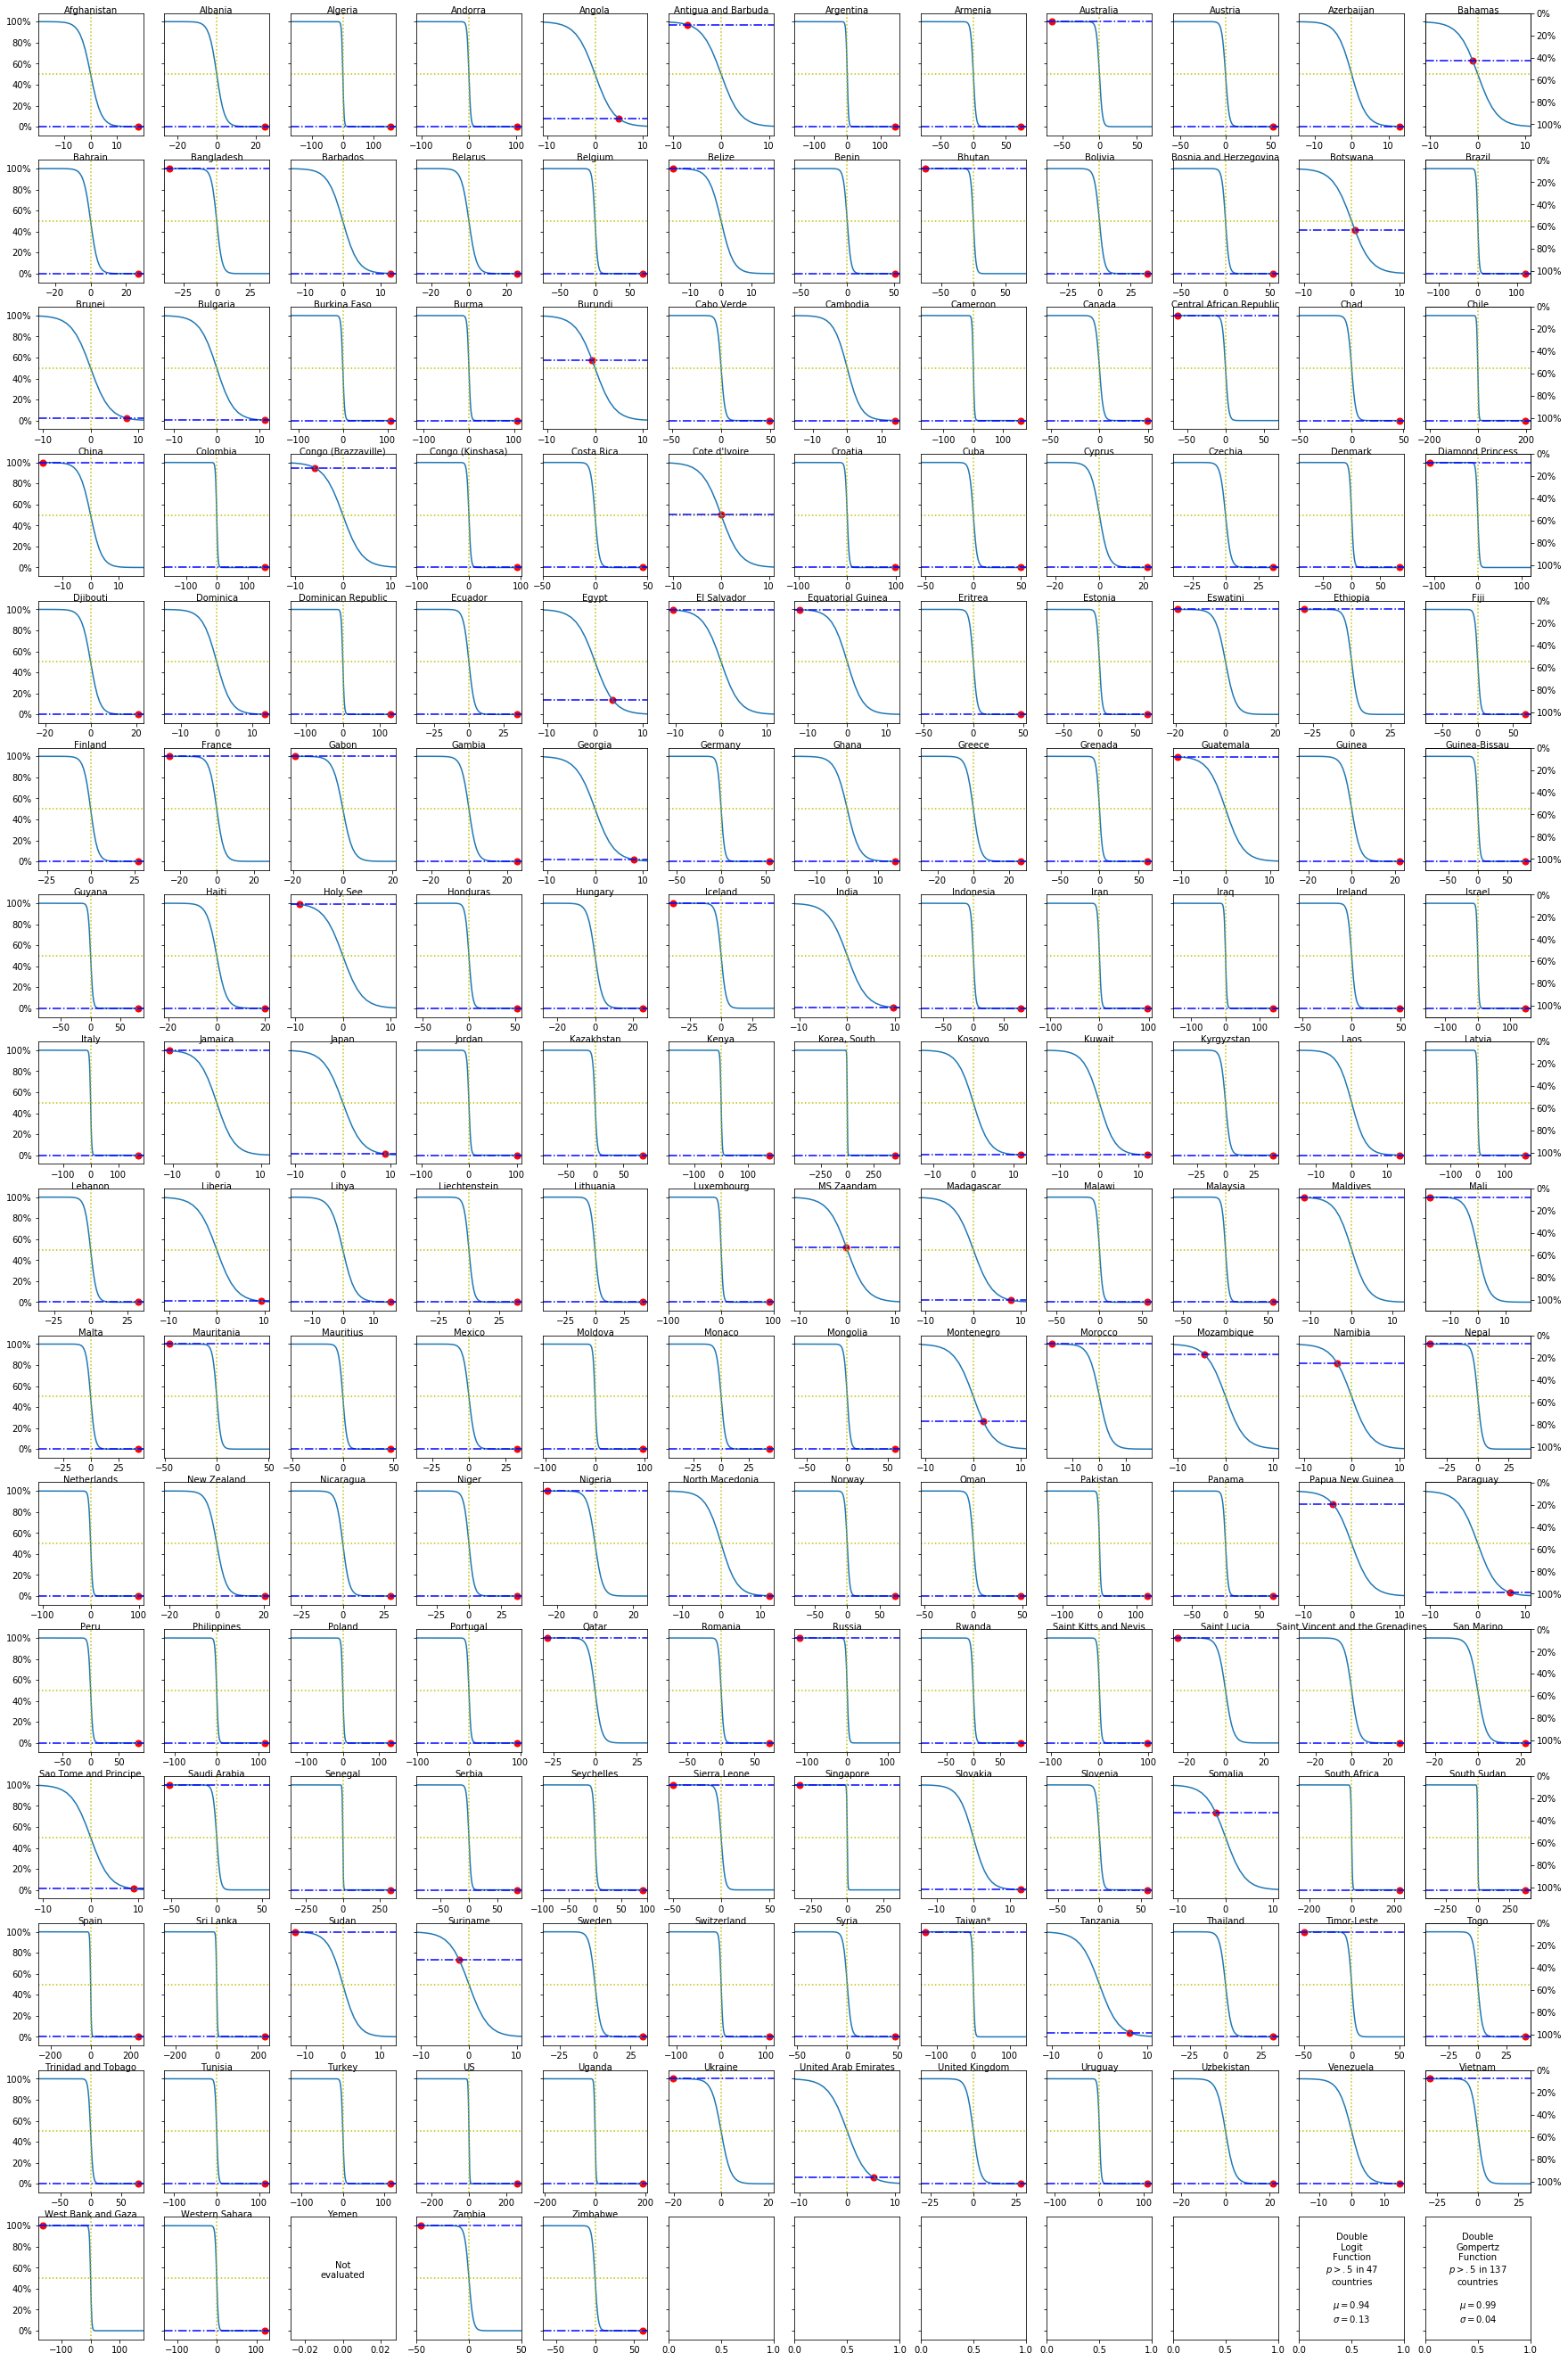

In [95]:
def AIC_distribution(diff):
    return np.exp(-.5 * diff) / (1 + np.exp(-.5 * diff))

evaluating = "Double Logit Function"

AICys.update({evaluating: np.array([])})

ncols = 12
nrows = int(np.ceil(df["measured"].size / ncols))

AICx = np.arange(-1e3, 1e3, 1)
AICy = AIC_distribution(AICx) * 100

fig, axs = plt.subplots(nrows, ncols, figsize=(30, 3 * nrows), sharey=True)

for i, country in enumerate(tqdm(df["measured"].index)):
    axs.flat[i].set_title(country, pad=-.5, fontsize=10)
    
    df1 = df[evaluating][country]
    df2 = df["Double Gompertz Function"][country]

    if not df1 or not df2:
        axs.flat[i].scatter([0], [0], alpha=0)
        axs.flat[i].text(0, 50, "Not\nevaluated", ha="center")
        continue

    AICdiff = df[evaluating][country].aic - df["Double Gompertz Function"][country].aic
    _y = AIC_distribution(AICdiff)
    AICys[evaluating] = np.append(AICys[evaluating], _y)
    axs.flat[i].plot(AICx, AICy)
    axs.flat[i].scatter(
        AICdiff, _y * 100,
        c="r", s=50
    )
    xlim = max(10, abs(AICdiff)) * 1.1
    axs.flat[i].set_xlim(-xlim, xlim)
    axs.flat[i].axvline(0, ls=":", c="y")
    axs.flat[i].axhline(50, ls=":", c="y")
    axs.flat[i].axhline(_y * 100, ls="-.", c="b")
    if i % ncols == ncols - 1:
        ax2 = axs.flat[i].twinx()
        ax2.set_ylim(110, -.110)
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

axs.flat[0].yaxis.set_major_formatter(mtick.PercentFormatter())

AICys1 = AICys[evaluating][AICys[evaluating]>.5]
AICys2 = AICys[evaluating][AICys[evaluating]<.5]
axs.flat[-2].text(
    x=.5, y=50, ha="center", va="center",
    s="""
{fname}
$p > .5$ in {num}
countries

$\mu = {mu:.2f}$
$\sigma = {sig:.2f}$
    """.format(
        fname=evaluating.replace(" ", "\n"),
        num=AICys1.size, mu=np.mean(AICys1), sig=np.std(AICys1)
    )
)
axs.flat[-1].text(
    x=.5, y=50, ha="center", va="center",
    s="""
{fname}
$p > .5$ in {num}
countries

$\mu = {mu:.2f}$
$\sigma = {sig:.2f}$
    """.format(
        fname="Double Gompertz Function".replace(" ", "\n"),
        num=AICys2.size, mu=np.mean(1 - AICys2), sig=np.std(1 - AICys2)
    )
)

plt.show()

In [105]:
print("Akaike's weights report")
print("")
print("Total countries evaluated {}".format(df["measured"].size - 1))
print("Total records per country {}".format(df["measured"]["China"].size))
for f in AICys:
    AICys1 = AICys[f][AICys[f]>.5]
    AICys2 = AICys[f][AICys[f]<.5]
    print("---------------------------")
    print(f"Double Gompertz Function VS {f}")
    print("- Double Gompertz Function")
    print("\tp>.5 in {} countries".format(AICys2.size))
    print("\tm={:.2f}  s={:.2f}".format(np.mean(1 - AICys2), np.std(1 - AICys2)))
    print(f"- {f}")
    print("\tp>.5 in {} countries".format(AICys1.size))
    print("\tm={:.2f}  s={:.2f}".format(np.mean(AICys1), np.std(AICys1)))

Akaike's weights report

Total countries evaluated 184
Total records per country 98
---------------------------
Double Gompertz Function VS Double Logit Function
- Double Gompertz Function
	p>.5 in 137 countries
	m=0.99  s=0.04
- Double Logit Function
	p>.5 in 47 countries
	m=0.94  s=0.13
---------------------------
Double Gompertz Function VS Logit Function
- Double Gompertz Function
	p>.5 in 158 countries
	m=0.99  s=0.07
- Logit Function
	p>.5 in 26 countries
	m=0.96  s=0.09
---------------------------
Double Gompertz Function VS Gompertz Function
- Double Gompertz Function
	p>.5 in 153 countries
	m=0.99  s=0.05
- Gompertz Function
	p>.5 in 31 countries
	m=0.95  s=0.06


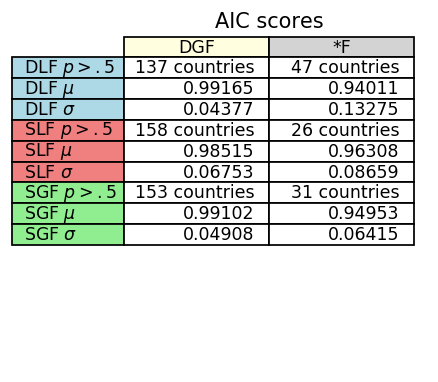

In [196]:
aic_table = []
rowLabels = []
colors = ["lightblue", "lightcoral", "lightgreen"]
rowColors = []

for i, f in enumerate(AICys):
    AICys1 = AICys[f][AICys[f]>.5]
    AICys2 = AICys[f][AICys[f]<.5]
    aic_table.append([
        f"{AICys2.size} countries", f"{AICys1.size} countries",
    ])
    aic_table.append([
        f"{np.mean(1 - AICys2):.5f}", f"{np.mean(AICys1):.5f}",
    ])
    aic_table.append([
        f"{np.std(AICys2):.5f}", f"{np.std(AICys1):.5f}",
    ])
    _f = "".join([w[0] for w in f.split(" ")])
    if len(_f) == 2:
        _f = "S" + _f
    rowLabels.append(f"{_f} $p > .5$")
    rowLabels.append(f"{_f} $\mu$")
    rowLabels.append(f"{_f} $\sigma$")
    rowColors.append(colors[i])
    rowColors.append(colors[i])
    rowColors.append(colors[i])

fig, ax = plt.subplots(figsize=(3, 1), dpi=125)
plt.axis('tight')
plt.axis("off")
ax.table(
    cellText=aic_table,
    colLabels=["DGF", "*F"],
    rowLabels=rowLabels,
    rowColours=rowColors,
    loc="top", colColours=["lightyellow", "lightgrey"]
)
plt.title("AIC scores", pad=125)
plt.show()

In [180]:
BICys = {}

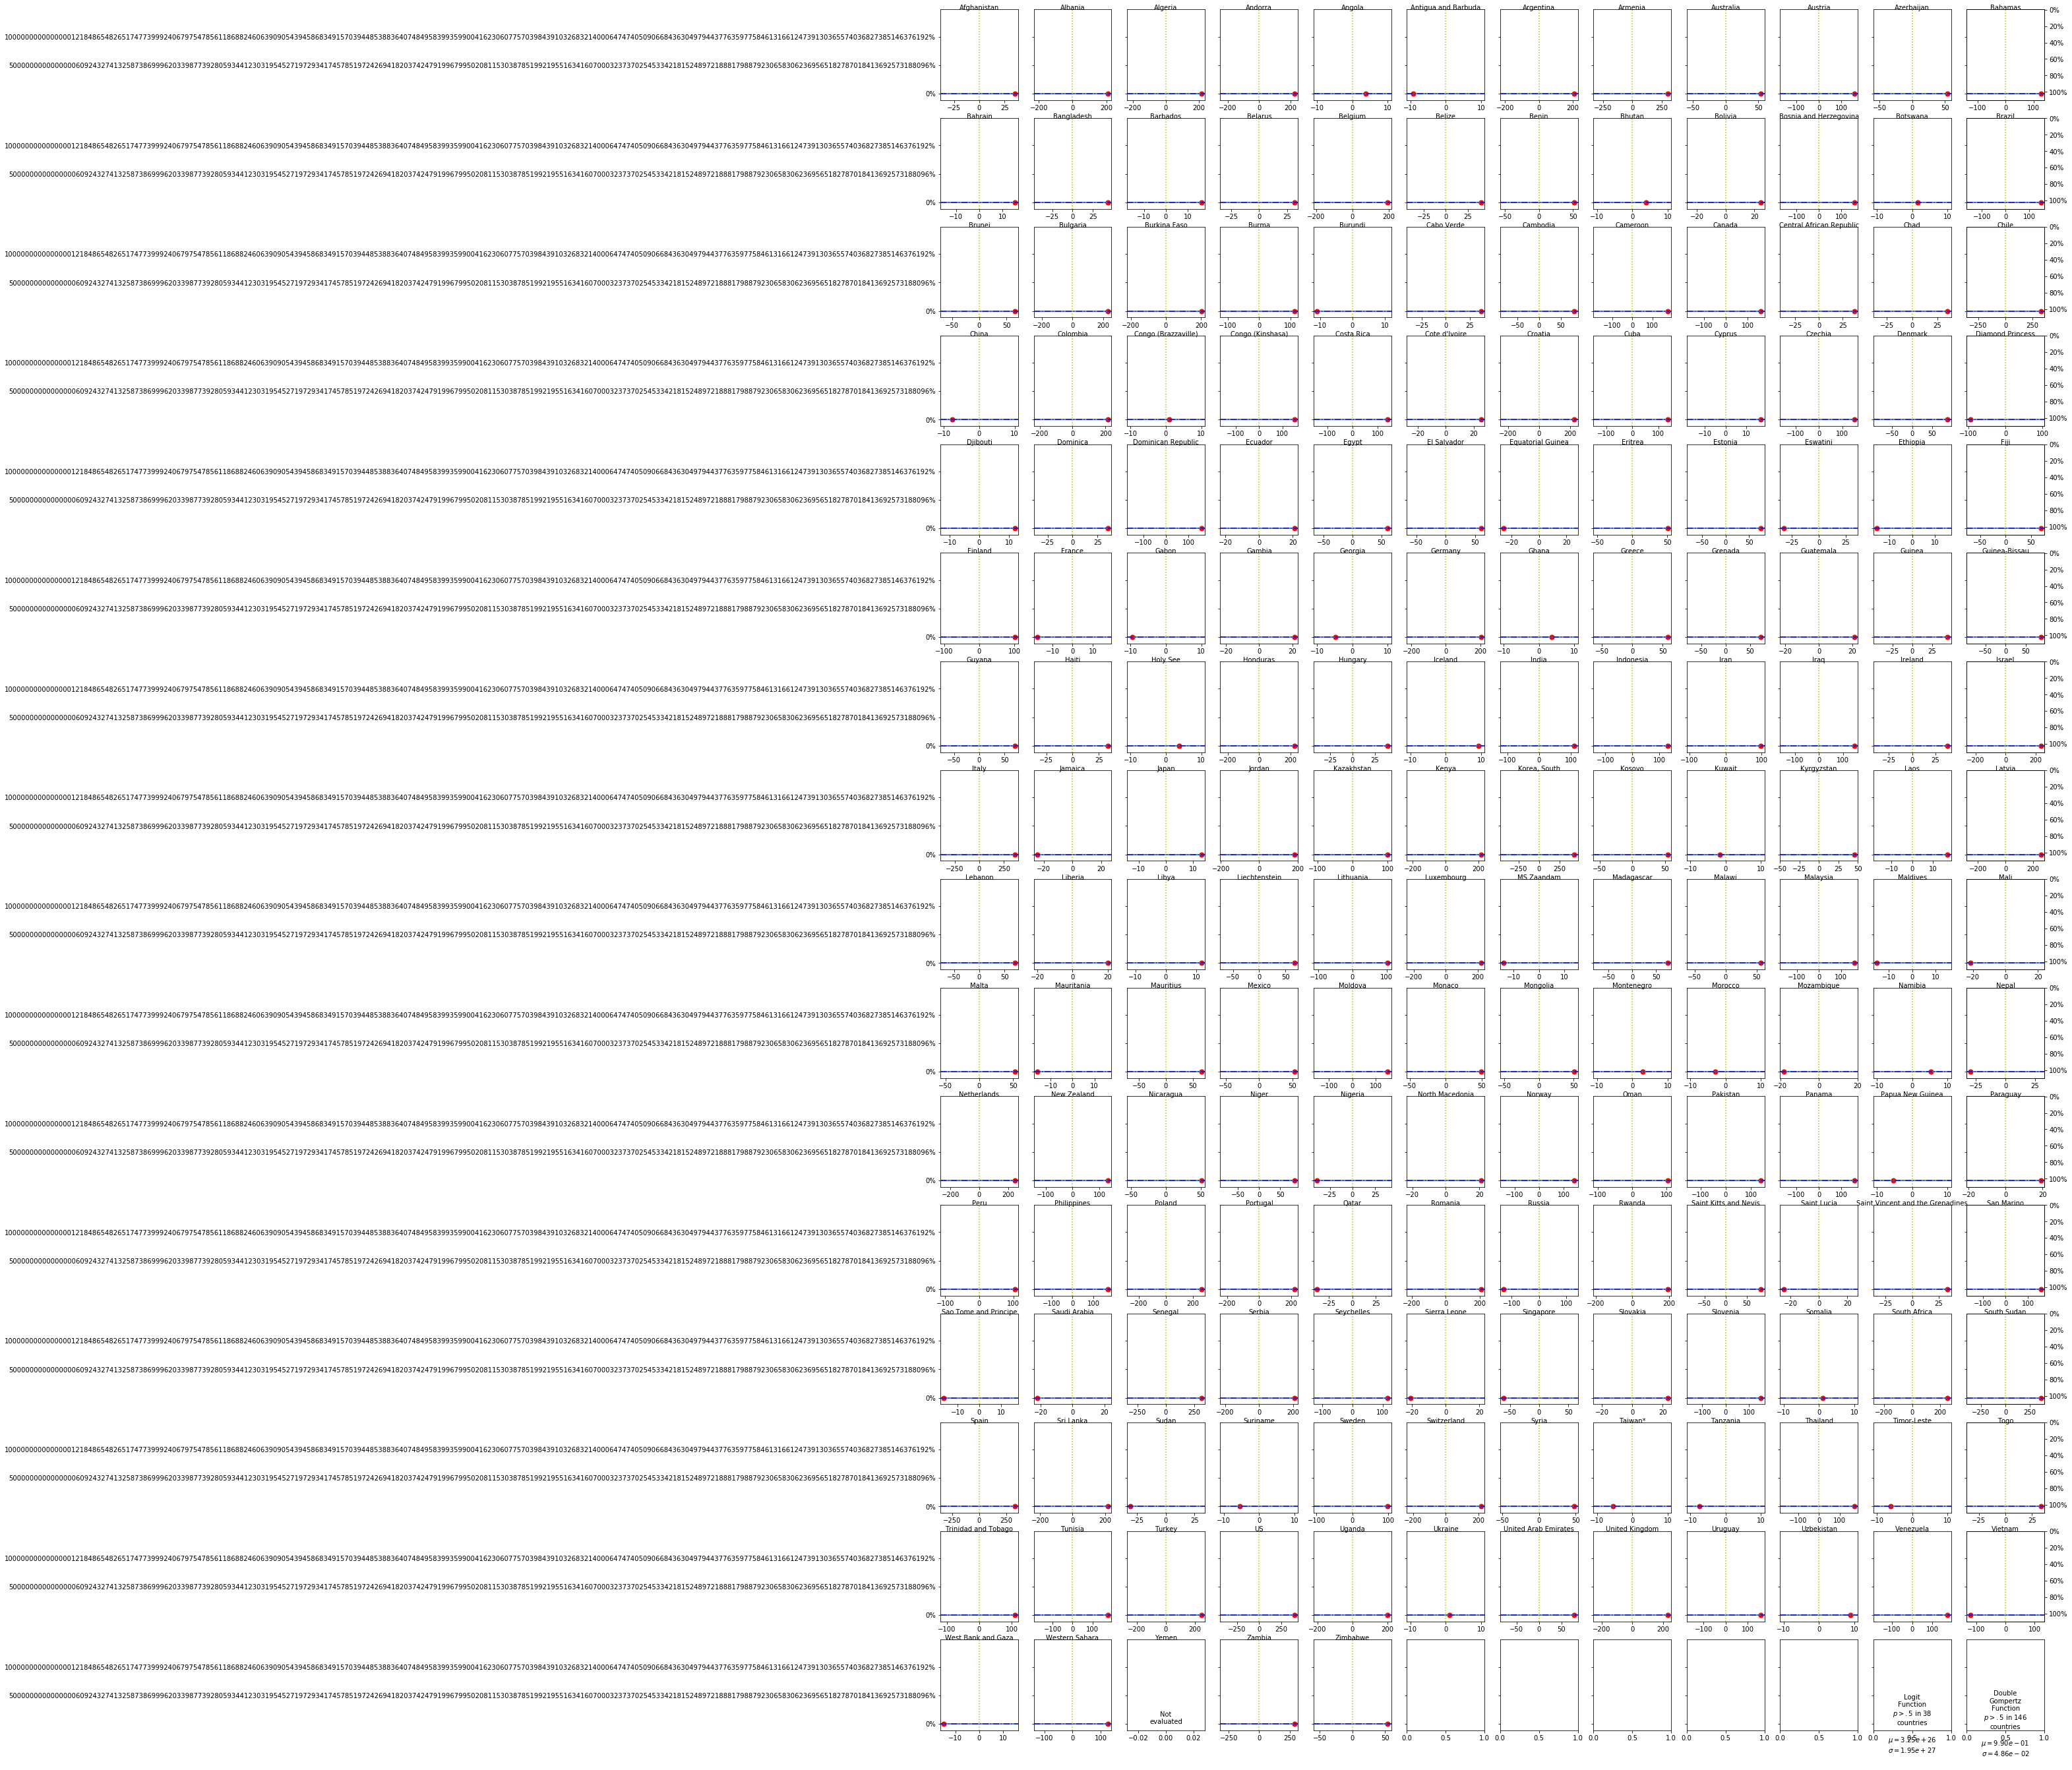

In [182]:
def BIC_distribution(diff):
    return np.exp(diff / -2)

evaluating = "Logit Function"

BICys.update({evaluating: np.array([])})

ncols = 12
nrows = int(np.ceil(df["measured"].size / ncols))

BICx = np.arange(-1e3, 1e3, 1)
BICy = BIC_distribution(BICx) * 100

fig, axs = plt.subplots(nrows, ncols, figsize=(30, 3 * nrows), sharey=True)

for i, country in enumerate(tqdm(df["measured"].index)):
    axs.flat[i].set_title(country, pad=-.5, fontsize=10)
    
    df1 = df[evaluating][country]
    df2 = df["Double Gompertz Function"][country]

    if not df1 or not df2:
        axs.flat[i].scatter([0], [0], alpha=0)
        axs.flat[i].text(0, .5, "Not\nevaluated", ha="center")
        continue

    BICdiff = df[evaluating][country].bic - df["Double Gompertz Function"][country].bic
    _y = BIC_distribution(BICdiff)
    BICys[evaluating] = np.append(BICys[evaluating], _y)
    axs.flat[i].plot(BICx, BICy)
    axs.flat[i].scatter(
        BICdiff, _y * 100,
        c="r", s=50
    )
    xlim = max(10, abs(BICdiff)) * 1.1
    axs.flat[i].set_xlim(-xlim, xlim)
    axs.flat[i].axvline(0, ls=":", c="y")
    axs.flat[i].axhline(50, ls=":", c="y")
    axs.flat[i].axhline(_y * 100, ls="-.", c="b")
    if i % ncols == ncols - 1:
        ax2 = axs.flat[i].twinx()
        ax2.set_ylim(110, -.110)
        ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

axs.flat[0].yaxis.set_major_formatter(mtick.PercentFormatter())

BICys1 = BICys[evaluating][BICys[evaluating]>.5]
BICys2 = BICys[evaluating][BICys[evaluating]<.5]
axs.flat[-2].text(
    x=.5, y=50, ha="center", va="center",
    s="""
{fname}
$p > .5$ in {num}
countries

$\mu = {mu:.2e}$
$\sigma = {sig:.2e}$
    """.format(
        fname=evaluating.replace(" ", "\n"),
        num=BICys1.size, mu=np.mean(BICys1), sig=np.std(BICys1)
    )
)
axs.flat[-1].text(
    x=.5, y=50, ha="center", va="center",
    s="""
{fname}
$p > .5$ in {num}
countries

$\mu = {mu:.2e}$
$\sigma = {sig:.2e}$
    """.format(
        fname="Double Gompertz Function".replace(" ", "\n"),
        num=BICys2.size, mu=np.mean(1 - BICys2), sig=np.std(1 - BICys2)
    )
)

plt.show()

In [183]:
df["Double Gompertz Function"]["Italy"].bic

1273.357631029497

In [185]:
df["Logit Function"]["Italy"].bic

1631.2652535476693

In [193]:
np.exp((df["Double Logit Function"]["China"].bic - df["Double Gompertz Function"]["China"].bic) / -2)

5155.653870128065

In [194]:
df["measured"]

countries
Afghanistan           [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Albania               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Algeria               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Andorra               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Angola                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                                            ...                        
West Bank and Gaza    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Western Sahara        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Yemen                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Zambia                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Zimbabwe              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: measured, Length: 185, dtype: object